In [51]:
import os
import pickle
import numpy as np                                                                                                                      
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [52]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary)

<bound method Model.summary of <Functional name=functional_2, built=True>>


In [53]:
'''features = {}
directory = os.path.join('kaggle/Images')
print(os.listdir(directory))
for img_name in os.listdir(directory):
    print('Feature extraction started for', img_name)
    img_path =  directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature
'''

"features = {}\ndirectory = os.path.join('kaggle/Images')\nprint(os.listdir(directory))\nfor img_name in os.listdir(directory):\n    print('Feature extraction started for', img_name)\n    img_path =  directory + '/' + img_name\n    image = load_img(img_path, target_size=(224, 224))\n    image = img_to_array(image)\n    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))\n    image = preprocess_input(image)\n    feature = model.predict(image, verbose=0)\n    image_id = img_name.split('.')[0]\n    features[image_id] = feature\n"

In [54]:
#pickle.dump(features, open(os.path.join('features.pkl'), 'wb'))

In [55]:
with open(os.path.join('features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [56]:
with open(os.path.join('kaggle/captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [57]:
mapping = {}
for line in captions_doc.split('\n'):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)
    
     

In [58]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption


In [59]:
clean(mapping)

In [60]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [61]:
len(all_captions)

40455

In [62]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [63]:
vocab_size

8485

In [64]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [65]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [66]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [67]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [68]:
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - loss: 5.7976
227/227 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - loss: 4.0799
227/227 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - loss: 3.5906
227/227 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - loss: 3.3096
227/227 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - loss: 3.1090
227/227 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - loss: 2.9533
227/227 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - loss: 2.8344
227/227 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - loss: 2.7394
227/227 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - loss: 2.6548
227/227 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - loss: 2.5837
227/227 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - loss: 2.5222
227/227 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - loss: 2.4709
227/227 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - loss: 2.4163
227/227 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - loss: 2.3710
227/227 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - loss: 2.3252
227/227 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - loss: 2.2866
227/227 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - loss: 2.2541
227/227 ━━━━━━━━━━━━━━━━━━━━ 26

In [69]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [70]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [71]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in test:
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.513414
BLEU-2: 0.290109


In [72]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("kaggle/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man on bicycle riding down rocky hill endseq
startseq man rides his dirt bike down rocky trail endseq
startseq person rides bike down rocky hill endseq
startseq blurry picture of mountain biker descending rocky trail endseq
startseq the mountain biker in blue rides down rocky path endseq
--------------------Predicted--------------------
startseq woman rides bike down rocky path endseq


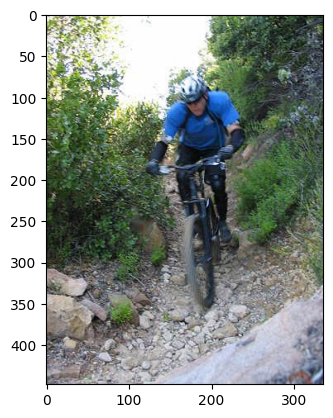

In [87]:
generate_caption('124881487_36e668145d.jpg')

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def predict_output_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("kaggle/Images", image_name)
    image = Image.open(img_path)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    return y_pred

In [ ]:
predict_output_caption('124881487_36e668145d.jpg')

In [1]:
#This is to save the model , it will get saved in the root directory
model.save('IC_MODEL.keras')

#To load the model , do this , make sure the model is in the root directory as well
from tensorflow.keras.models import load_model
loaded_model = load_model('IC_MODEL.keras')
#changes saved

NameError: name 'model' is not defined